In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

spark = SparkSession.builder \
    .appName("MobilePriceClassification") \
    .getOrCreate()


25/12/26 13:53:02 WARN Utils: Your hostname, spark resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/12/26 13:53:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/26 13:53:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load Data
data = spark.read.csv(
    "train.csv",
    header=True,
    inferSchema=True
)

data.printSchema()
data.show(5)


root
 |-- battery_power: integer (nullable = true)
 |-- blue: integer (nullable = true)
 |-- clock_speed: double (nullable = true)
 |-- dual_sim: integer (nullable = true)
 |-- fc: integer (nullable = true)
 |-- four_g: integer (nullable = true)
 |-- int_memory: integer (nullable = true)
 |-- m_dep: double (nullable = true)
 |-- mobile_wt: integer (nullable = true)
 |-- n_cores: integer (nullable = true)
 |-- pc: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- ram: integer (nullable = true)
 |-- sc_h: integer (nullable = true)
 |-- sc_w: integer (nullable = true)
 |-- talk_time: integer (nullable = true)
 |-- three_g: integer (nullable = true)
 |-- touch_screen: integer (nullable = true)
 |-- wifi: integer (nullable = true)
 |-- price_range: integer (nullable = true)

+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------

In [3]:
# Data Preparation
# Casting label to DoubleType for Spark ML
data = data.withColumn("price_range", data["price_range"].cast(DoubleType()))

feature_cols = data.columns
feature_cols.remove("price_range")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_final = assembler.transform(data)

In [4]:
# Split Data (80% Train, 20% Test)
train, test = data_final.randomSplit([0.8, 0.2], seed=42)

print("Train count:", train.count())
print("Test count:", test.count())


25/12/26 13:53:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Train count: 1642
Test count: 358


In [5]:
# --- MODEL 1: LOGISTIC REGRESSION ---
print("Training Logistic Regression Model...")
lr = LogisticRegression(labelCol="price_range", featuresCol="features")
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)

Training Logistic Regression Model...


In [6]:
# --- MODEL 2: RANDOM FOREST ---
print("Training Random Forest Model...")
rf = RandomForestClassifier(labelCol="price_range", featuresCol="features", numTrees=100)
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)

Training Random Forest Model...


In [7]:
# --- EVALUATION METRICS ---

evaluator_acc = MulticlassClassificationEvaluator(labelCol="price_range", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="price_range", predictionCol="prediction", metricName="f1")
evaluator_prec = MulticlassClassificationEvaluator(labelCol="price_range", predictionCol="prediction", metricName="weightedPrecision")
evaluator_rec = MulticlassClassificationEvaluator(labelCol="price_range", predictionCol="prediction", metricName="weightedRecall")

lr_acc = evaluator_acc.evaluate(lr_predictions)
rf_acc = evaluator_acc.evaluate(rf_predictions)
rf_f1 = evaluator_f1.evaluate(rf_predictions)
rf_precision = evaluator_prec.evaluate(rf_predictions)
rf_recall = evaluator_rec.evaluate(rf_predictions)

print("\n" + "="*30)
print("FINAL RESULTS")
print("="*30)
print(f"Logistic Regression Accuracy: {lr_acc:.2f}")
print(f"Random Forest Accuracy:       {rf_acc:.2f}")
print(f"Random Forest Precision:      {rf_precision:.2f}")
print(f"Random Forest Recall:         {rf_recall:.2f}")
print(f"Random Forest F1 Score:       {rf_f1:.2f}")
print("="*30 + "\n")


FINAL RESULTS
Logistic Regression Accuracy: 0.96
Random Forest Accuracy:       0.84
Random Forest Precision:      0.84
Random Forest Recall:         0.84
Random Forest F1 Score:       0.83



Graph 5 Saved: graph_5_detailed_metrics.png


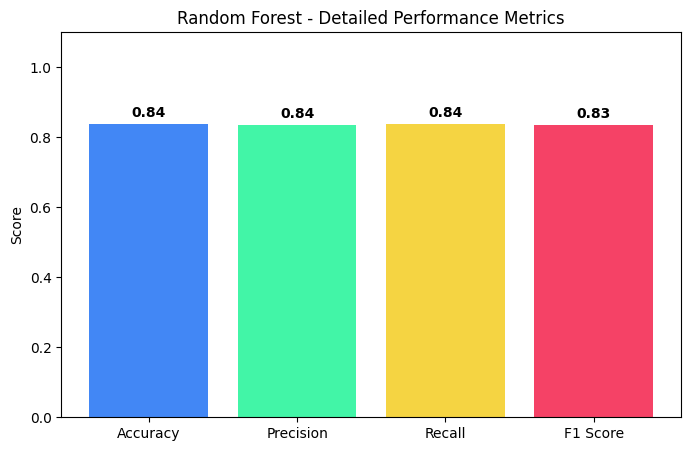

In [8]:
# Visualize Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [rf_acc, rf_precision, rf_recall, rf_f1]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['#4287f5', '#42f5a7', '#f5d442', '#f54266'])

plt.ylim(0, 1.1)
plt.title('Random Forest - Detailed Performance Metrics')
plt.ylabel('Score')

# Add text labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', fontweight='bold')

plt.savefig('graph_5_detailed_metrics.png')
print("Graph 5 Saved: graph_5_detailed_metrics.png")

Graph 1 Saved: graph_1_confusion_matrix_LR.png


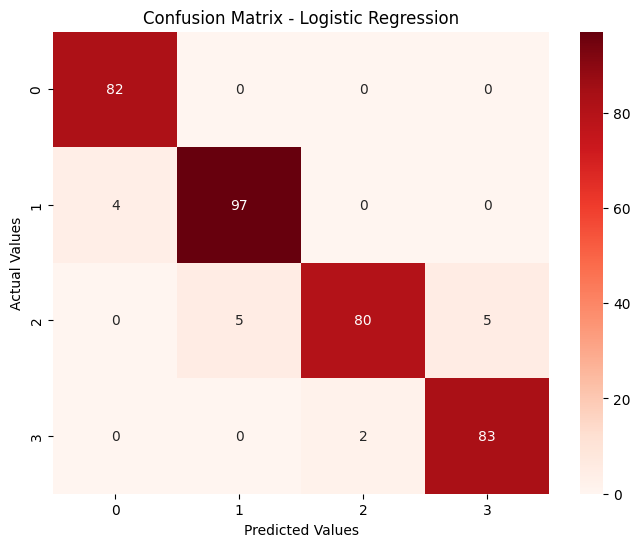

In [9]:
# GRAPH 1: Confusion Matrix (Logistic Regression)
# ==========================================
y_true_lr = lr_predictions.select("price_range").toPandas()
y_pred_lr = lr_predictions.select("prediction").toPandas()

cm_lr = confusion_matrix(y_true_lr, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Reds', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig('graph_1_confusion_matrix_LR.png')
print("Graph 1 Saved: graph_1_confusion_matrix_LR.png")

Graph 2 Saved: graph_2_confusion_matrix_RF.png


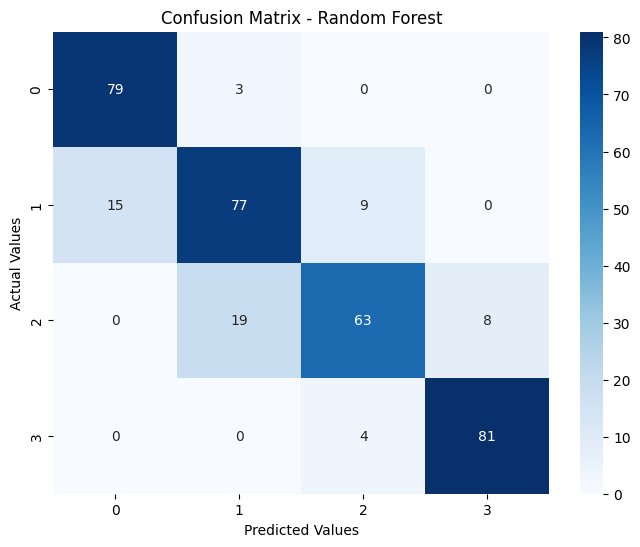

In [10]:
# GRAPH 2: Confusion Matrix (Random Forest)
# ==========================================
y_true_rf = rf_predictions.select("price_range").toPandas()
y_pred_rf = rf_predictions.select("prediction").toPandas()

cm_rf = confusion_matrix(y_true_rf, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig('graph_2_confusion_matrix_RF.png')
print("Graph 2 Saved: graph_2_confusion_matrix_RF.png")

Graph 3 Saved: graph_3_feature_importance.png


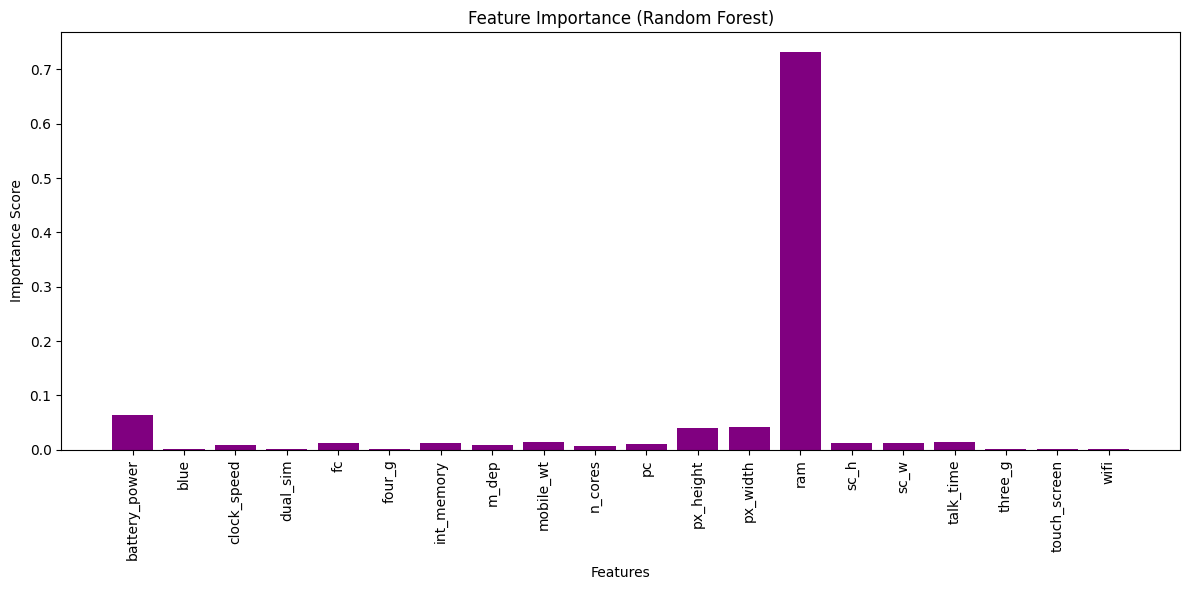

In [11]:
# GRAPH 3: Feature Importance (Only for Random Forest)
# ==========================================
importances = rf_model.featureImportances
x_values = list(range(len(importances)))

plt.figure(figsize=(12, 6))
plt.bar(x_values, importances, orientation = 'vertical', color='purple')
plt.xticks(x_values, feature_cols, rotation=90)
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.savefig('graph_3_feature_importance.png')
print("Graph 3 Saved: graph_3_feature_importance.png")

Graph 4 Saved: graph_4_accuracy_comparison.png


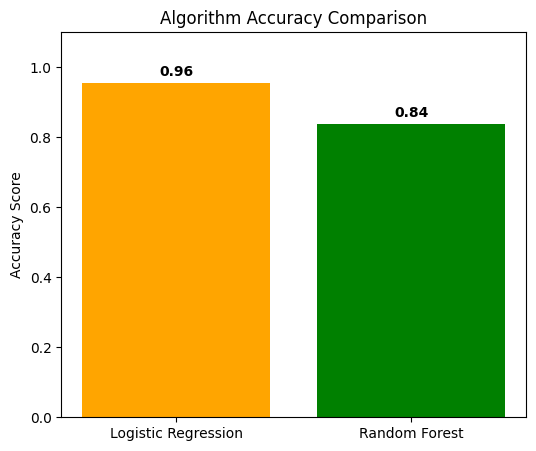

In [12]:
# GRAPH 4: Algorithm Comparison (Accuracy)
# ==========================================
algos = ['Logistic Regression', 'Random Forest']
scores = [lr_acc, rf_acc]

plt.figure(figsize=(6, 5))
plt.bar(algos, scores, color=['orange', 'green'])
plt.ylim(0, 1.1)
plt.title('Algorithm Accuracy Comparison')
plt.ylabel('Accuracy Score')
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.savefig('graph_4_accuracy_comparison.png')
print("Graph 4 Saved: graph_4_accuracy_comparison.png")